# Part 1

## Logging Configuration

In [1]:
import logging

logging.basicConfig(
    format='[%(asctime)s] %(name)s:%(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

## Loading & Preprocessing

In [2]:
from pathlib import Path

import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder


def get_files(path, extension):
    return Path(path).glob(f'*.{extension}')


def get_images(path, extension='jpg'):
    for filename in get_files(path, extension):
        yield filename, Image.open(filename)


def get_resized_images(path, extension='jpg', size=None):
    for filename, image in get_images(path, extension):
        yield filename, image.resize(size) if size is not None else image

In [3]:
def load_images(path, size=None):
    images, labels = [], []
    for filename, image in get_resized_images(path, size=size):
        images.append(np.ravel(np.asarray(image)))
        labels.append(filename.name[0])

    if size is None and any(len(_) != len(images[0]) for _ in images):
        max_lenth = len(max(images, key=lambda vector: len(vector)))

        _ = np.zeros((len(images), max_lenth), dtype='uint8')
        for index, image in enumerate(images):
            _[index][0:len(image)] = image

        images = _
    else:
        images = np.array(images, dtype='uint8')

    labels = np.array(LabelEncoder().fit_transform(labels))

    return images, labels

In [4]:
def loadImages(path):
    return load_images(path, (100, 100))

In [5]:
data, labels = loadImages('./img')

## PCA & Visualization

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def pca(data, n_components=2):
    normalized = MinMaxScaler().fit_transform(data)

    pca = PCA(n_components=n_components).fit(normalized)

    return pca.transform(normalized), pca.explained_variance_ratio_

In [7]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_image(axes, x, y, image, zoom=1):
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)

    artists = []
    for x, y in zip(x, y):
        ab = AnnotationBbox(im, (x, y), xycoords='data')
        artists.append(axes.add_artist(ab))

    axes.update_datalim(np.column_stack([x, y]))
    axes.autoscale()

    return artists

In [8]:
import matplotlib.pyplot as plt

def plot_images(xy, images):
    axes = plt.gca()

    for (x, y), image in zip(xy, images):
        scatter_image(axes, x, y, image, zoom=0.5)
        plt.scatter(x, y)

    plt.title("Principal Component Analysis of Seasonal Images")
    plt.xlabel('Component #1')
    plt.ylabel('Component #2')
    plt.xlim(
            xy[:,0].min() * 1.5,
            xy[:,0].max() * 1.5
    )
    plt.ylim(
            xy[:,1].min() * 1.5,
            xy[:,1].max() * 1.5
    )
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

In [9]:
def PCA_ImageSpaceVisualization(X):
    xy, _ = pca(data)

    images = [
        Image.fromarray(image.reshape(100, 100, 3), 'RGB')
        for image in X
    ]

    plot_images(xy, images)

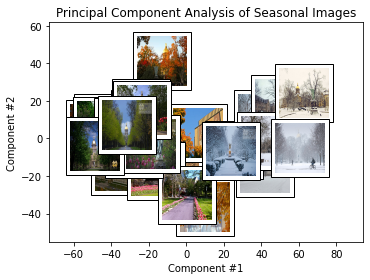

In [10]:
PCA_ImageSpaceVisualization(data)

As you can see from the previous plot, pictures featuring similar color palletes are close to each other.

Given that the showcased pictures were captured during different seasons, which we know for sure feature different color palletes, this translates to images corresponding to the same season being grouped together, whilst images corresponding to different seasons drifting apart.

The above observation can be translated in higher dimensions.To be more specific, images appearing further away in the above plot are less coorelated to each other.

Given that pictures taken during the same season should theoretically showcase little to no variance to one another, this behavior is to be expected.

## Classification using KNN &  SVM

In [11]:
logger = logging.getLogger('KNN_SVM_COMPARISON')

In order to compare the accuracy of the KNN & SVM models regarding the classification of the images we are going to be using the `accuracy_score` function provided by `scikit-learn`, which, as stated in the `scikit-learn` documentation, in binary and multiclass classification, this function is equal to the `jaccard_score` function."

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct and is given by the following formula

$$J = \frac{\left \| X \bigcap Y \right \|}{\left \| X \bigcup  Y \right \|}$$

`X` corresponds to the set of labels, predicted by the model at hand, and `Y` to the set containing the real labels.

In [12]:
from functools import wraps

def cache(method):
    path = Path.cwd() / f"{method.__name__}.csv"

    @wraps(method)
    def wrapper(*args, **kwargs):
        if path.is_file():
            return pd.read_csv(
                path,
                index_col=0, sep=r'\s*,\s*', engine='python'
            )
        
        df = pd.DataFrame(method(*args, **kwargs))

        if not path.parent.is_dir():
            path.parent.mkdir(parents=True)

        df.to_csv(path)

        return df

    return wrapper

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def kfold_accuracy(model, data, labels, n_splits=5, shuffle=True):
    kfold = KFold(n_splits=n_splits, shuffle=shuffle)

    scores = []
    for train_indices, test_indices in kfold.split(data):
        train_data = data[train_indices]
        train_labels = labels[train_indices]

        model.fit(train_data, train_labels)

        test_data = data[test_indices]
        test_labels = labels[test_indices]

        predict_labels = model.predict(test_data)

        score = accuracy_score(
            test_labels, predict_labels,
            normalize=True
        )

        scores.append(score * 100)

    return sum(scores) / n_splits

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import pandas as pd

@cache
def knn_svm_comparison(data, labels, runs, n_components):
    datasets = {
        'original': data,
        'reduced': pca(data, n_components)[0]
    }

    models = {
        'svm': LinearSVC(),
        'knn': KNeighborsClassifier(n_neighbors=1)
    }

    results = []
    for run in range(runs):
        for model_tag, model in models.items():
            for dataset_tag, dataset in datasets.items():
                logger.info(
                    "Run: %02d, Model: %s, Dataset: %s" % (
                        run, model_tag, dataset_tag
                    )
                )

                score = kfold_accuracy(model, dataset, labels)
                results.append({
                    "Model": model_tag,
                    "Dataset": dataset_tag,
                    "Score": score
                })
    
                logger.info("Score: %05.2f" % (score,))

    return pd.DataFrame(results)

In [15]:
(data, labels) = load_images('./img', size=None)

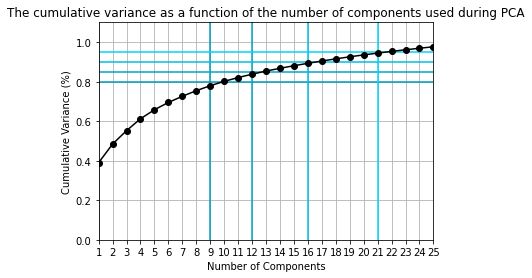

In [16]:
n_components = 25

_, variance = pca(data, n_components=n_components)

x, y = np.arange(1, n_components + 1), np.cumsum(variance)

plt.axhline(y=0.80, color='#009bba', linestyle='-')
plt.axvline(x=np.where(y > 0.80)[0][0], color='#009bba', linestyle='-')

plt.axhline(y=0.85, color='#00a6c7', linestyle='-')
plt.axvline(x=np.where(y > 0.85)[0][0], color='#00a6c7', linestyle='-')

plt.axhline(y=0.90, color='#00bee3', linestyle='-')
plt.axvline(x=np.where(y > 0.90)[0][0], color='#00bee3', linestyle='-')

plt.axhline(y=0.95, color='#03d3fc', linestyle='-')
plt.axvline(x=np.where(y > 0.95)[0][0], color='#03d3fc', linestyle='-')

plt.plot(x, y, marker='o', linestyle='-', color='k')

plt.xlim((1, n_components))
plt.ylim((0, 1.1))

plt.xticks(x)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.title(
    'The cumulative variance '
    'as a function of the number of components used during PCA'
)

plt.grid()
plt.show()

It is obvious from the plot above, that in order to get over **95%** of variance explained, we need **21** principal components.

In [17]:
df = knn_svm_comparison(data, labels, 5, 21)

**Notice:** `scikit-learn` offers a way of automatically determining the number of components required in order to achieve any amount of variance explained.

According to `scikit-learn` documentation

_If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components._



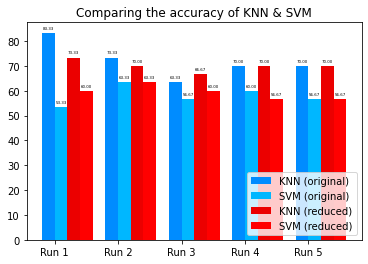

In [18]:
runs = 5

knn_data, svm_data = df[df['Model'] == 'knn'], df[df['Model'] == 'svm']

s1 = knn_data[knn_data['Dataset'] == 'original']['Score']
s2 = svm_data[svm_data['Dataset'] == 'original']['Score']
s3 = knn_data[knn_data['Dataset'] == 'reduced']['Score']
s4 = svm_data[svm_data['Dataset'] == 'reduced']['Score']

indices, w = np.arange(runs), 0.2

c = ['#008cff', '#00b7ff', '#eb0000', '#ff0000']

_, axes = plt.subplots()

p1 = axes.bar(indices + 0 * w, s1, w, color=c[0],label='KNN (original)')
p2 = axes.bar(indices + 1 * w, s2, w, color=c[1],label='SVM (original)')
p3 = axes.bar(indices + 2 * w, s3, w, color=c[2],label='KNN (reduced)')
p4 = axes.bar(indices + 3 * w, s4, w, color=c[3],label='SVM (reduced)')

for barplot in [p1, p2, p3, p4]:
    for bar in barplot:
        height = bar.get_height()
        axes.annotate(
            f'{height:05.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=4
        )

axes.set_title('Comparing the accuracy of KNN & SVM')
axes.set_xticks(indices + w / 2)
axes.set_xticklabels([f'Run {run + 1}' for run in range(runs)])

axes.legend(loc='lower right')
axes.autoscale_view()
plt.show()


It is clear that the **1-NN** model performs better than the Linear SVM model.



# Part 2

In [19]:
logger = logging.getLogger('NMF')

In [20]:
import numpy as np

def error(X, W, C, l):
    return np.linalg.norm(X - np.dot(W, C)) / np.linalg.norm(X)

    
def get_new_c(X, W, C, l):
    return C * np.divide(np.dot(W.T, X), l * C + np.dot(np.dot(W.T, W), C))


def get_new_w(X, W, C, l):
    return W * np.divide(np.dot(X, C.T), l * W + np.dot(W, np.dot(C, C.T)))

In [21]:
def reg_nmf(X, k=2, l=0, e=1e-12):
    n, m = X.shape
    low, high = X.min(), X.max()

    W = np.random.uniform(low=low, high=high, size=(n, k))
    C = np.random.uniform(low=low, high=high, size=(k, m))

    e_current, e_previous, it = error(X, W, C, l), float('inf'), 0
    while e_previous - e_current >= e:
        if it % 2:
            C = get_new_c(X, W, C, l)
        else:
            W = get_new_w(X, W, C, l)

        e_previous, e_current, it = e_current, error(X, W, C, l), it + 1

    return W, C, it

## Gathering Metrics

In [22]:
@cache
def nmf_convergence(ks, es):
    n, m, low, high = 500, 1000, 0, 1

    X = np.random.uniform(low=low, high=high, size=(n, m))

    columns, data = ['k', 'e', 'Iterations', 'Time'], []

    for k in sorted(ks):
        for e in sorted(es):
            logger.info("k: %d, e: %.1e" % (k, e))
            W, C, iterations = reg_nmf(X, k=k, e=e)
            
            data.append(dict(zip(columns, [k, e, iterations])))

    return pd.DataFrame(data)

In [23]:
ks, es = [1, 10, 100], [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

df = nmf_convergence(ks, es)

In [24]:
def iterations_with_respect_to(field, df, ratio=False):
    verbose = {
        'e': 'acceptable error margin',
        'k': 'number of components'
    }

    for value in df[field].unique():
        subset = df[df[field] == value]

        other_field = 'k' if field == 'e' else 'e'

        if field == 'e':
            label = f'{field} = {value:e}'
        else:
            label = f'{field} = {value:d}'

        x, y = subset[other_field], subset['Iterations']

        if ratio is True:
            y = [
                (y.iloc[i] / y.iloc[i - 1])
                if i - 1 >= 0 else 1
                for i in range(len(y))
            ]

        plt.plot(x, y, label=label)

    if field == 'e':
        plt.xlim(df[other_field].min(), df[other_field].max())
    else:
        plt.xlim(df[other_field].max(), df[other_field].min())

    plt.ylim(df['Iterations'].min() - 1, df['Iterations'].max() + 1)

    plt.xscale('log')
    plt.yscale('linear')

    plt.xticks(df[other_field])

    plt.xlabel(field.title())
    plt.ylabel('Iterations')

    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.title(
        f'The number of iterations '
        f'as a function of '
        f'the {verbose[other_field]}'
    )
    plt.show()

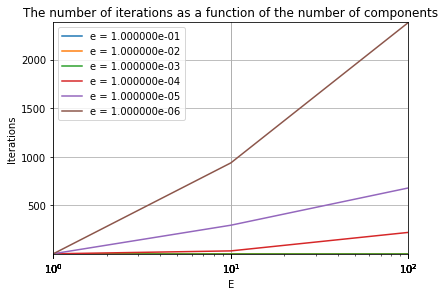

In [25]:
iterations_with_respect_to('e', df)

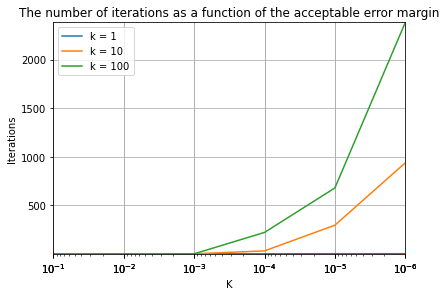

In [26]:
iterations_with_respect_to('k', df)